In [84]:
import json
from static_checks.Checker import *
from common.path_utils import get_data_path
import pandas as pd
from plotnine import ggplot, aes, geom_point, theme_minimal, labs, scale_x_continuous, scale_y_continuous

In [104]:
"""
An ItemForecast dict is a dict of the form:

{
    ...,
    elicited_prob: float,
    elicitation_metadata: {
        "P": ItemForecast,
        "check1": tuple_forecast,
        "check2": tuple_forecast,
        ...
    }
}

A tuple_forecast dict is a dict of the form:

{
    "P": ItemForecast,
    "Q": ItemForecast,
    ...
}

We want to write a function which, given a tuple_forecast, returns a TupleInconsistency dict of the form:

{
    viol: float,
    metadata: {
        "P": {
            "check1": TupleInconsistency,
            "check2": TupleInconsistency,
            ...
        },
        "Q": {
            "check1": TupleInconsistency,
            "check2": TupleInconsistency,
            ...
        },
        ...
    }
}

"""

checkers = {
    "NegChecker": NegChecker(),
    "ParaphraseChecker": ParaphraseChecker(),
    "AndChecker": AndChecker(),
    "OrChecker": OrChecker(),
    "AndOrChecker": AndOrChecker(),
    "ButChecker": ButChecker(),
    "CondChecker": CondChecker(),
    "CondCondChecker": CondCondChecker(),
    "ConsequenceChecker": ConsequenceChecker(),
}


def inconsistency(checker_name: str, tuple_forecast: dict[str, Any]):
   
    tuple_forecast_probs = {k: v['elicited_prob'] for k, v in tuple_forecast.items()}
    viol = checkers[checker_name].violation(tuple_forecast_probs)
    
    metadata = {}
    
    for k, item_forecast in tuple_forecast.items():
        if "elicitation_metadata" in item_forecast:
            elicitation_metadata = item_forecast["elicitation_metadata"]
            metadata[k] = {}
            for check_name, check_dict in elicitation_metadata.items():
                if check_name == "P":
                    continue
                check_dict_with_P = {"P": elicitation_metadata["P"]} | check_dict
                metadata[k][check_name] = inconsistency(check_name, check_dict_with_P)

    return {"viol": viol, "metadata": metadata}


def extract_viols(result: dict, checker_name: str):
    viols = []
    viols.append(result['viol'])
    result_next = result.get('metadata', {}).get('P', {}).get(checker_name, {})
    if result_next:
        viols.extend(extract_viols(result_next, checker_name))
    return viols

def plot_extracted_viols(viols):
    # Create a DataFrame with the violations and their indices
    df = pd.DataFrame({
        'Violation': viols,
        'Depth': range(len(viols)-1, -1, -1)  # Reverse order
    })
    
    # Create the plot
    plot = (ggplot(df, aes(x='Depth', y='Violation'))
            + geom_point(size=3)
            # + scale_y_continuous(limits=(0, 1))
            + labs(title='Violations by Depth',
                   x='Depth',
                   y='Violation')
            + theme_minimal())
    
    return plot



C:\Users\abhim\AppData\Local\Temp\ipykernel_8596\4126941461.py:8: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


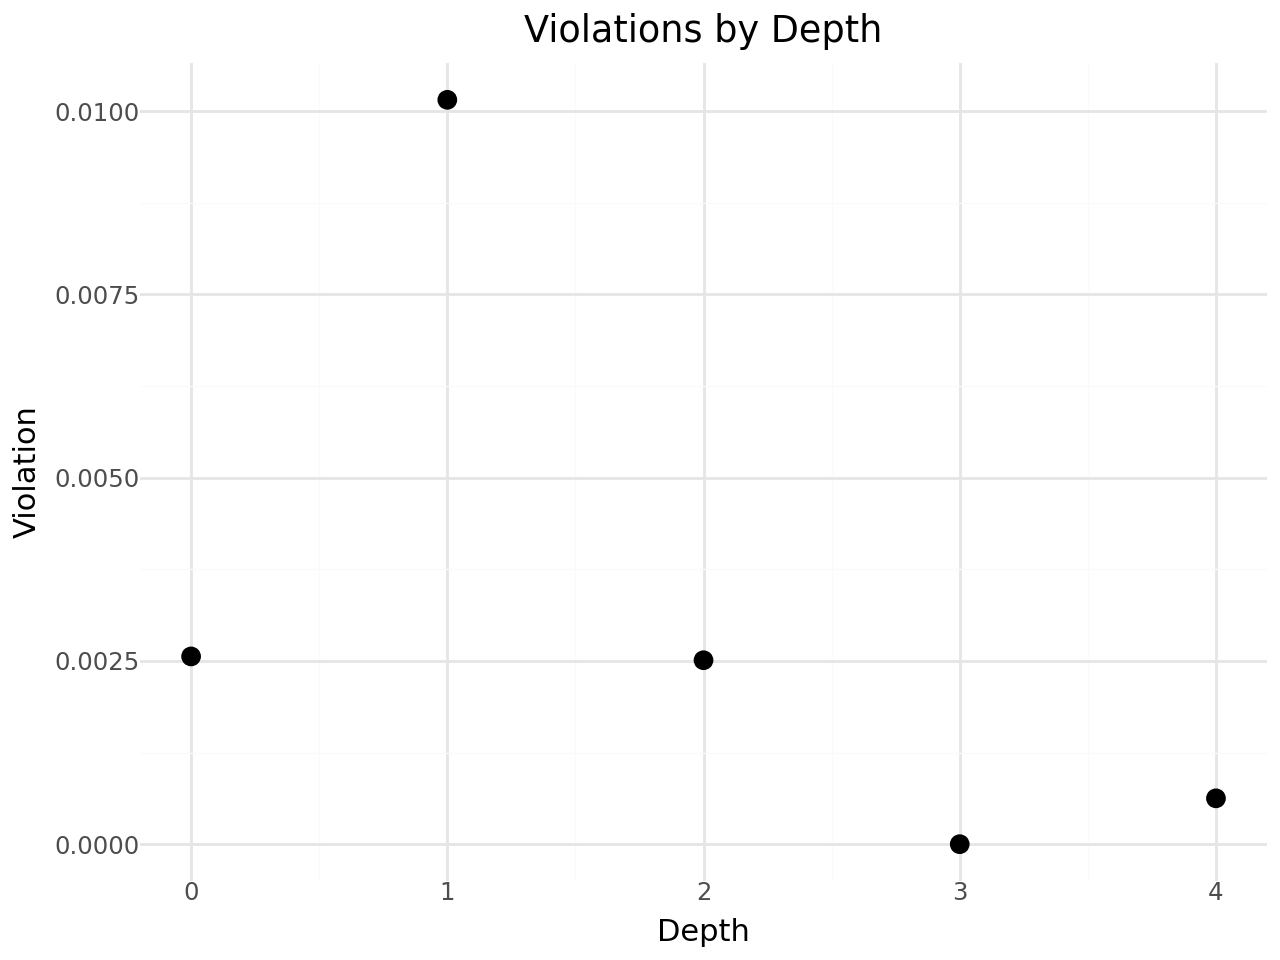

In [124]:
# Usage example:
# file_path = get_data_path() / 'forecasts' / 'ConsistentForecaster_08-23-22-13' / 'NegChecker.jsonl'
file_path = get_data_path() / 'forecasts' / 'ConsistentForecaster_08-24-07-53' / 'ParaphraseChecker.jsonl'
tuple_forecasts = load_tuple_forecasts(file_path)
result = inconsistency("ParaphraseChecker", tuple_forecasts[13])
v=extract_viols(result, "ParaphraseChecker")
plot = plot_extracted_viols(v)
print(plot)

In [ ]:
#%%

from static_checks.Checker import *
from time import time

checkers = {
    "para": {"answers": {"P": 0.4, "para_P": 0.8}, "checker": ParaphraseChecker()},
    "neg": {"answers": {"P": 0.6, "not_P": 0.8}, "checker": NegChecker()},
    "cond": {
        "answers": {"P": 0.15, "Q_given_P": 0.6, "P_and_Q": 0.15},
        "checker": CondChecker(),
    },
    "andor": {
        "answers": {"P": 0.6, "Q": 0.6, "P_and_Q": 0.55, "P_or_Q": 0.6},
        "checker": AndOrChecker(),
    },
    "but": {
        "answers": {"P": 0.6, "Q_and_not_P": 0.3, "P_or_Q": 0.94},
        "checker": ButChecker(),
    },
    "condcond": {
        "answers": {
            "P": 0.5,
            "Q_given_P": 0.5,
            "R_given_P_and_Q": 0.5,
            "P_and_Q_and_R": 0.16,
        },
        "checker": CondCondChecker(),
    },
    "cons": {"answers": {"P": 0.5, "cons_P": 0.45}, "checker": ConsequenceChecker()},
}

for k, v in checkers.items():
    checker = v["checker"]
    if k != "neg":
        continue
    answers = v["answers"]
    print("Checker:", k)
    time0 = time()
    result_plain = checker.max_min_arbitrage(answers)
    time1 = time()
    print("No kwargs:", result_plain, "\nTime:", time1 - time0)
    print("\n\n")
    result_weighted = checker.max_min_arbitrage(answers, scoring=[0.5, 0.2])
    print("Weighted:", result_weighted, "\nTime:", time() - time1)

In [ ]:
# %%

from forecasters.consistent_forecaster import ConsistentForecaster
from forecasters.basic_forecaster import BasicForecaster
from common.datatypes import ForecastingQuestion
from static_checks.Checker import *
from time import time

cf = ConsistentForecaster(
    BasicForecaster(),
    checks=[
        NegChecker(),
        AndOrChecker(),
        CondChecker(),
        ParaphraseChecker(),
    ],
)
fq = ForecastingQuestion(
    title="Will Manhattan have a skyscraper a mile tall by 2030?",
    body=(
        "Resolves YES if at any point before 2030, there is at least "
        "one building in the NYC Borough of Manhattan (based on current "
        "geographic boundaries) that is at least a mile tall."
    ),
    resolution_date="2030-01-01T00:00:00",
    question_type="binary",
    data_source="manifold",
    url="https://www.metaculus.com/questions/12345/",
    metadata={"foo": "bar"},
    resolution=None,
)

import asyncio

# x = cf.call(fq)
x = asyncio.run(cf.call_async(
    fq,
    bq_func_kwargs={"model": "gpt-4o-mini"},
    instantiation_kwargs={"model": "gpt-4o-mini"},
    model="gpt-4o-mini",
))
# x = asyncio.run(cf.call_async(fq))

In [ ]:
# %%

print(f"{x=}")

raise

In [ ]:
# %%

from static_checks.Checker import *
from time import time

checkers = {
    "para": {"answers": {"P": 0.4, "para_P": 0.43}, "checker": ParaphraseChecker()},
    "neg": {"answers": {"P": 0.6, "not_P": 0.57}, "checker": NegChecker()},
    "cond": {
        "answers": {"P": 0.15, "Q_given_P": 0.6, "P_and_Q": 0.15},
        "checker": CondChecker(),
    },
    "andor": {
        "answers": {"P": 0.6, "Q": 0.6, "P_and_Q": 0.55, "P_or_Q": 0.6},
        "checker": AndOrChecker(),
    },
    "but": {
        "answers": {"P": 0.6, "Q_and_not_P": 0.3, "P_or_Q": 0.94},
        "checker": ButChecker(),
    },
    "condcond": {
        "answers": {
            "P": 0.5,
            "Q_given_P": 0.5,
            "R_given_P_and_Q": 0.5,
            "P_and_Q_and_R": 0.16,
        },
        "checker": CondCondChecker(),
    },
    "cons": {"answers": {"P": 0.5, "cons_P": 0.45}, "checker": ConsequenceChecker()},
}

for k, v in checkers.items():
    checker = v["checker"]
    answers = v["answers"]
    if k != "cons":
        continue
    print("Checker:", k)
    time0 = time()
    result_shgo = checker.max_min_arbitrage(answers, methods=("shgo",))
    time1 = time()
    print("SHGO:", result_shgo, "\nTime:", time1 - time0)
    result_diff_evol = checker.max_min_arbitrage(
        answers, methods=("differential_evolution",)
    )
    time2 = time()
    print("Diff Evolution:", result_diff_evol, "\nTime:", time2 - time1)
    result_dual_annealing = checker.max_min_arbitrage(
        answers, methods=("dual_annealing",)
    )
    time3 = time()
    print("Dual Annealing:", result_dual_annealing, "\nTime:", time3 - time2)
    result_basinhopping = checker.max_min_arbitrage(answers, methods=("basinhopping",))
    time4 = time()
    print("Basinhopping:", result_basinhopping, "\nTime:", time4 - time3)
    result_plain = checker.max_min_arbitrage(answers)
    time5 = time()
    print("No kwargs:", result_plain, "\nTime:", time5 - time4)
    print("\n\n")


# print('----------------')
# print(CondChecker().min_arbitrage(ex, exa))
# print('----------------')
# print(CondChecker().arbitrage(outcome1, ex, exa))
# print(CondChecker().arbitrage(outcome2, ex, exa))
# print(CondChecker().arbitrage(outcome3, ex, exa))
# print('----------------')

In [ ]:
# %%

import json
from common.datatypes import (
    ForecastingQuestion_stripped,
    ForecastingQuestion,
    Prob_cot,
    Prob,
    PlainText,
)
from common.llm_utils import query_api_chat_sync, query_api_chat_sync_native
import os

fq = ForecastingQuestion(
    title="Will Manhattan have a skyscraper a mile tall by 2030?",
    body=(
        "Resolves YES if at any point before 2030, there is at least "
        "one building in the NYC Borough of Manhattan (based on current "
        "geographic boundaries) that is at least a mile tall."
    ),
    resolution_date="2030-01-01T00:00:00",
    question_type="binary",
    data_source="manifold",
    url="https://www.metaculus.com/questions/12345/",
    metadata={"foo": "bar"},
    resolution=None,
)

fqs = ForecastingQuestion_stripped(
    title="Will Manhattan have a skyscraper a mile tall by 2030?",
    body=(
        "Resolves YES if at any point before 2030, there is at least "
        "one building in the NYC Borough of Manhattan (based on current "
        "geographic boundaries) that is at least a mile tall."
    ),
)

print(fqs.__str__())

In [ ]:
# %%

# os.environ["USE_OPENROUTER"] = "True"
messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant. Summarize the question for the user.",
    },
    {"role": "user", "content": fq.__str__()},
]
# response = query_api_chat_sync(messages=messages, verbose=True, model="mistralai/mistral-large")